### main_pretrain

In [3]:
from main_pretrains.main_gpt2 import main_pretrain
from models.llama import LlamaSOH
from data_provider import data_provider
import torch
import torch.optim as optim
import random
import numpy as np

source_set_train, source_loader_train = data_provider(name = 'GOTION', shuffle_flag=True, batch_size=10, flag = 'train')
source_set_test, source_loader_test = data_provider(name = 'GOTION', shuffle_flag=False, batch_size=10, flag = 'test')

# Model parameters
input_dim = 1
llama_model_path = './llms'

# Training parameters
mask_ratio = 0.3
num_epochs = 15
LR = 1e-3

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
f_g = LlamaSOH(input_dim, llama_model_path, PPA=True, soft_prompt_len=10).to(device)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, f_g.parameters()), lr=LR)
set_seed(0)
# Assuming train_loader and test_loader are already defined
main_pretrain(train_loader= source_loader_train, test_loader= source_loader_test, model=f_g, optimizer=optimizer, device=device, mask_ratio=mask_ratio, num_epochs=num_epochs)
torch.save(f_g.state_dict(), 'saved_models/llama/f_g.pt')

GOTION train 2840
GOTION test 1419
cuda


OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like huggyllama/llama-7b is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

### prob (PG-SSL)

In [9]:
from main_pretrains.main_gpt2_prob import main_prob
import torch.nn as nn

target_set_train, target_loader_train = data_provider(name = 'CALCE', shuffle_flag=False, batch_size=10, flag = 'train')
target_set_test, target_loader_test = data_provider(name = 'CALCE', shuffle_flag=False, batch_size=10, flag = 'test')

LR = 1e-3
EPOCH = 3

f_g = GPT2SOH(input_dim, gpt2_model_path, PPA=True, soft_prompt_len=10).to(device)
f_g.load_state_dict(torch.load("saved_models/gpt2+ppa/f_g.pt"))

regressor = nn.Linear(f_g.input_linear.out_features, 1).to(device)
optimizer = optim.AdamW(regressor.parameters(), lr=LR)

set_seed(2)
main_prob(source_loader_train, target_loader_train, combined_training=True, model=f_g, regressor=regressor, optimizer=optimizer, device=device, num_epochs=EPOCH)
torch.save(regressor.state_dict(), 'saved_models/gpt2+ppa/regressor.pt')

CALCE train 1173
CALCE test 637


d:\Applications\Anaconda\envs\batteryML\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch [1/3], Source Loader Loss: 0.01195490742583401
Target Loader - MAE: 0.018868058919906616, RMSE: 0.022543979808688164
Epoch [2/3], Source Loader Loss: 7.438995030689755e-05
Target Loader - MAE: 0.018100904300808907, RMSE: 0.021802708506584167
Epoch [3/3], Source Loader Loss: 5.0421617551121376e-05
Target Loader - MAE: 0.018462400883436203, RMSE: 0.02197338081896305


(637,)
(637,)


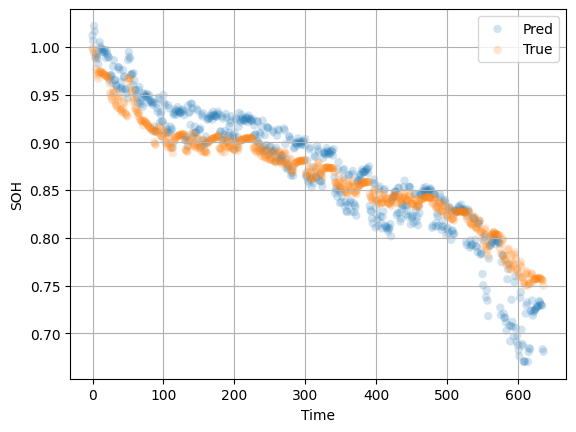

In [10]:
from drawings import drawDegradation
drawDegradation(target_loader_test=target_loader_test, model=f_g, regressor=regressor, device = device, model_name = 'gpt2')

### tta (PPA)

In [20]:
from main_pretrains.main_gpt2_tta import main_tta
from evaluator import evaluate

f_g = GPT2SOH(input_dim, gpt2_model_path, PPA=True, soft_prompt_len=10).to(device)
f_g.load_state_dict(torch.load("saved_models/gpt2+ppa/f_g.pt"))
regressor = nn.Linear(f_g.input_linear.out_features, 1).to(device)
regressor.load_state_dict(torch.load("saved_models/gpt2+ppa/regressor.pt"))

mae, rmse = evaluate(model = f_g, regressor=regressor, target_loader=target_loader_test, device=device, model_name='gpt2')
print(f"(Before TTA) MAE: {mae}, RMSE: {rmse}")

# 冻结GPT-2模型的所有参数
# for param in f_g.gpt2.parameters():
#     param.requires_grad = False


for name, param in f_g.gpt2.named_parameters():
    if not any(layer in name.lower() for layer in ['ln', 'wpe', 'wte']):
        param.requires_grad = False

# Print trainable and frozen parameters
print("Trainable parameters:")
trainable_params_count = 0
for name, param in f_g.named_parameters():
    if name =='soft_prompt':
        print('PPA params:', param.numel())
    if param.requires_grad:
        print(name)
        trainable_params_count += param.numel()

print("\nFrozen parameters:")
frozen_params_count = 0
for name, param in f_g.named_parameters():
    if not param.requires_grad:
        print(name)
        frozen_params_count += param.numel()

print(f"\nNumber of trainable parameters: {trainable_params_count}")
print(f"Total number of parameters: {trainable_params_count + frozen_params_count}")
print(f"Number of frozen parameters: {frozen_params_count}")


d:\Applications\Anaconda\envs\batteryML\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


(Before TTA) MAE: 0.019478710368275642, RMSE: 0.02454531379044056
Trainable parameters:
PPA params: 7680
soft_prompt
input_linear.weight
input_linear.bias
gpt2.wte.weight
gpt2.wpe.weight
gpt2.h.0.ln_1.weight
gpt2.h.0.ln_1.bias
gpt2.h.0.ln_2.weight
gpt2.h.0.ln_2.bias
gpt2.h.1.ln_1.weight
gpt2.h.1.ln_1.bias
gpt2.h.1.ln_2.weight
gpt2.h.1.ln_2.bias
gpt2.h.2.ln_1.weight
gpt2.h.2.ln_1.bias
gpt2.h.2.ln_2.weight
gpt2.h.2.ln_2.bias
gpt2.h.3.ln_1.weight
gpt2.h.3.ln_1.bias
gpt2.h.3.ln_2.weight
gpt2.h.3.ln_2.bias
gpt2.h.4.ln_1.weight
gpt2.h.4.ln_1.bias
gpt2.h.4.ln_2.weight
gpt2.h.4.ln_2.bias
gpt2.h.5.ln_1.weight
gpt2.h.5.ln_1.bias
gpt2.h.5.ln_2.weight
gpt2.h.5.ln_2.bias
gpt2.h.6.ln_1.weight
gpt2.h.6.ln_1.bias
gpt2.h.6.ln_2.weight
gpt2.h.6.ln_2.bias
gpt2.h.7.ln_1.weight
gpt2.h.7.ln_1.bias
gpt2.h.7.ln_2.weight
gpt2.h.7.ln_2.bias
gpt2.h.8.ln_1.weight
gpt2.h.8.ln_1.bias
gpt2.h.8.ln_2.weight
gpt2.h.8.ln_2.bias
gpt2.h.9.ln_1.weight
gpt2.h.9.ln_1.bias
gpt2.h.9.ln_2.weight
gpt2.h.9.ln_2.bias
gpt2.h.10.ln_

In [21]:
#b optimizer = optim.SGD(filter(lambda p: p.requires_grad, f_g.parameters()), lr=1e-2)

optimizer = optim.SGD([f_g.soft_prompt], lr=1e-1, momentum=0.9)
set_seed(2)
mae, rmse = evaluate(model = f_g, regressor=regressor, target_loader=target_loader_test, device=device, model_name='gpt2')
print(f"(Before TTA) MAE: {mae}, RMSE: {rmse}")

main_tta(target_loader=target_loader_test, model=f_g, regressor=regressor, optimizer=optimizer, device=device, mask_ratio=0.9, num_epochs=10)

mae, rmse = evaluate(model = f_g, regressor=regressor, target_loader=target_loader_test, device=device, model_name='gpt2')
print(f"(After TTA) MAE: {mae}, RMSE: {rmse}")

(Before TTA) MAE: 0.019478710368275642, RMSE: 0.02454531379044056
Epoch [1/10], TTA Reconstruction Loss: 0.05741860039415769
Target Loader - MAE: 0.017260555177927017, RMSE: 0.024461006745696068
Epoch [2/10], TTA Reconstruction Loss: 0.04051232087658718
Target Loader - MAE: 0.017819784581661224, RMSE: 0.026526715606451035
Epoch [3/10], TTA Reconstruction Loss: 0.03323132867808454
Target Loader - MAE: 0.021314477548003197, RMSE: 0.02597932144999504


KeyboardInterrupt: 